In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

It seems that experimental noise does lead to more noise in the information footprint. However, my hypothesis is that the level of noise has to be bigger than the bin size (so as to facilitate a sufficient number of bin transitions) in order to lead to noise.

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Sliding energy matrix

In [6]:
def simrep_pbound(promoter_variant, rep_mut, p_emat, r_emat, n_p, n_r, n_NS,
                  ep_wt=0, er_wt=0):

    w_rnap_tot = 0
    for i in range(160 - p_emat.shape[0]):
        subseq = promoter_variant[i:(i + p_emat.shape[0])].upper()
        w_rnap = tregs.simulate.get_weight(subseq, p_emat, e_wt=ep_wt)
        w_rnap_tot += w_rnap

    w_rep = tregs.simulate.get_weight(rep_mut, r_emat, e_wt=er_wt)

    return (n_p / n_NS * w_rnap_tot) / (1 + n_p / n_NS * w_rnap_tot + n_r / n_NS * w_rep)

def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, O1_emat, n_p, n_r, n_NS,
                  ep_wt, er_wt):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rep_mut = mut[rep_start:rep_end].upper()
        rv['pbound'] = simrep_pbound(mut, rep_mut, rnap_emat, O1_emat,
                                     n_p, n_r, n_NS,
                                     ep_wt=ep_wt, er_wt=er_wt)
        l_tr.append(rv)
    df = pd.DataFrame.from_records(l_tr)

    return df

### Simulating PCR

In [7]:
def amplify(seq_cnt, rounds, alpha=10, beta=1.5):
    num_seqs = len(seq_cnt)
    for round in range(rounds):
        amp_factor = 1 + np.random.beta(a=alpha, b=beta, size=num_seqs)
        seq_cnt = np.multiply(seq_cnt, amp_factor)
    scaling_factor = 10**(len(str(int(min(seq_cnt)))) - 1)
    return seq_cnt / scaling_factor

In [8]:
def simrep_with_pcr(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
                    ep_wt, er_wt, n_NS, n_p, n_r,
                    num_mutants=1000,
                    rounds=20, alpha=10, beta=1.5):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=0.1,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                              rnap_emat, O1_emat, n_p, n_r, n_NS,
                              ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df))
    df['ct_0'] = dna_cnt
    df = df[df.ct_0 != 0.0]

    df['ct_1_original'] = df['ct_0'] * df['pbound']
    rna_cnt = amplify(df['ct_1_original'].to_numpy(), rounds, alpha=alpha, beta=beta)
    df['ct_1'] = rna_cnt
    #df['ct_1'] = 1 + df['ct_1'].astype(int) # adding 1 as a pseudocount
    
    df['ct_0'] = df['ct_0'].astype(float)
    df['ct_1'] = df['ct_1'].astype(float)
    df['noise'] = (df['ct_1'].to_numpy() / np.min(df['ct_1'])) / (df['ct_1_original'].to_numpy() / np.min(df['ct_1_original']))
    df['norm_ct_1'] = df['ct_1'] / df['ct_0']

    return df

### Random sampling

In [9]:
def random_sampling(df, n=10**5):
    df_large = df.loc[df.index.repeat(df.ct_1)]
    print(len(df_large))
    print('There are {} copies of RNA in total'.format(np.sum(df['ct_1'])))
    
    df_random = df_large.sample(n=n).drop_duplicates()
    print('The current library size is {}'.format(len(df_random)))
    print('Library diversity decreaes by {:.1f}%'.format( (1 - len(df_random) / len(df)) * 100))
    return df_random

### Combining PCR bias and random sampling

In [10]:
def get_footprint_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat,
                             ep_wt, er_wt, n_NS, n_p, n_r,
                             rounds=20, alpha=10, beta=1.5, sample_size=1000):
    df = simrep_with_pcr(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                    ep_wt, er_wt, n_NS, n_p, n_r,
                    num_mutants=1000,
                    rounds=rounds, alpha=alpha, beta=beta)

    df_random = random_sampling(df, n=sample_size)
    mut_list = df_random['seq'].values
    mu_data = df_random['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    return footprint, exshift_list, mu_data

In [11]:
n_NS = len(genome)
ep_wt, er_wt = -3, -10
n_p = 4600
n_r = 50

In [12]:
footprint, exshift_list, mu_data = get_footprint_with_noise(promoter, rnap_site, rep_site, rnap_emat, rep_emat,
                                                            ep_wt, er_wt, n_NS, n_p, n_r,
                                                            rounds=5, sample_size=10000)

16690
There are 17185.851956574326 copies of RNA in total
The current library size is 896
Library diversity decreaes by 10.4%


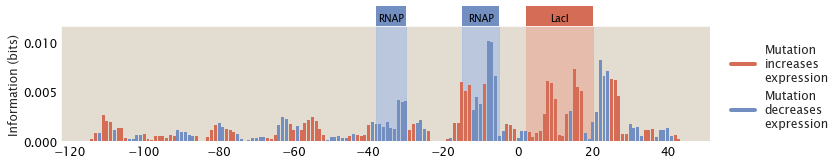

In [13]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/noisy_footprint.png', dpi=300, bbox_inches='tight')
plt.show()

## Simple activation

In [14]:
def simact_pbound(p_seq, a_seq, p_emat, a_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    p = (n_p / n_NS) * tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    a = (n_a / n_NS) * tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)
    w = np.exp(-e_ap)

    pbound = (p + a * p * w) / (1 + a + p + a * p * w)

    return pbound


def simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                  rnap_emat, act_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        act_mut = mut[act_start:act_end].upper()
        rv['pbound'] = simact_pbound(rnap_mut, act_mut, rnap_emat, act_emat,
                                     n_p, n_a, n_NS,
                                     ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)
        l_tr.append(rv)
    df = pd.DataFrame.from_records(l_tr)

    return df


def amplify(seq_cnt, rounds, alpha=10, beta=1.5):
    num_seqs = len(seq_cnt)
    for round in range(rounds):
        amp_factor = 1 + np.random.beta(a=alpha, b=beta, size=num_seqs)
        seq_cnt = np.multiply(seq_cnt, amp_factor)
    scaling_factor = 10**(len(str(int(min(seq_cnt)))) - 1)
    return seq_cnt / scaling_factor


def simact_with_pcr(wtseq, rnap_wtseq, act_wtseq,
           rnap_emat, act_emat, n_p, n_a, n_NS,
           ep_wt=0, ea_wt=0, e_ap=0,
           num_mutants=1000, scaling_factor=100,
           rounds=20, alpha=10, beta=1.5):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(
                                    wtseq,
                                    rate=0.1,
                                    num_mutants=num_mutants,
                                    number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    act_start, act_end = tregs.seq_utils.find_binding_site(wtseq, act_wtseq)

    df = simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                       rnap_emat, act_emat, n_p, n_a, n_NS,
                       ep_wt, ea_wt, e_ap)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df))
    df['ct_0'] = dna_cnt
    df = df[df.ct_0 != 0.0]

    df['ct_1_original'] = df['ct_0'] * df['pbound']
    rna_cnt = amplify(df['ct_1_original'].to_numpy(), rounds, alpha=alpha, beta=beta)
    df['ct_1'] = rna_cnt
    #df['ct_1'] = 1 + df['ct_1'].astype(int) # adding 1 as a pseudocount
    
    df['ct_0'] = df['ct_0'].astype(float)
    df['ct_1'] = df['ct_1'].astype(float)
    df['noise'] = (df['ct_1'].to_numpy() / np.min(df['ct_1'])) / (df['ct_1_original'].to_numpy() / np.min(df['ct_1_original']))
    df['norm_ct_1'] = df['ct_1'] / df['ct_0']

    return df


def random_sampling(df, n=10**5):
    df_large = df.loc[df.index.repeat(df.ct_1)]
    print(len(df_large))
    print('There are {} copies of RNA in total'.format(np.sum(df['ct_1'])))
    
    df_random = df_large.sample(n=n).drop_duplicates()
    print('The current library size is {}'.format(len(df_random)))
    print('Library diversity decreaes by {:.1f}%'.format( (1 - len(df_random) / len(df)) * 100))
    return df_random


def get_footprint_with_noise(wtseq, rnap_wtseq, act_wtseq,
                             rnap_emat, act_emat, n_p, n_a, n_NS,
                             ep_wt, ea_wt, e_ap, 
                             rounds=20, alpha=10, beta=1.5, sample_size=1000):
    
    df = simact_with_pcr(wtseq, rnap_wtseq, act_wtseq,
                         rnap_emat, act_emat, n_p, n_a, n_NS,
                         ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap,
                         num_mutants=1000,
                         rounds=rounds, alpha=alpha, beta=beta)

    df_random = random_sampling(df, n=sample_size)
    mut_list = df_random['seq'].values
    mu_data = df_random['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    return footprint, exshift_list, mu_data

In [15]:
def plot_footprint(footprint, exshift_list,
                   outfile=None):
    
    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-70, -52, alpha=0.7, color='#DCECCB')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-70, max(footprint)*1.15),
                                            18,
                                            max(footprint) * 0.2,
                                            facecolor='#7AA974',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-70 + 0.5 * 18, max(footprint) * 1.2, 'CRP', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'
crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [17]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -7
ea_wt = -15
e_ap = -7

96077
There are 96574.02687563872 copies of RNA in total
The current library size is 874
Library diversity decreaes by 12.6%


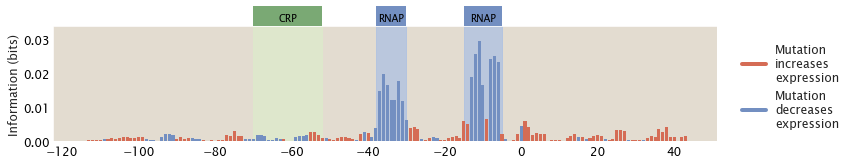

In [18]:
footprint, exshift_list, mu_data = get_footprint_with_noise(promoter, rnap_site, crp_site,
                                                            rnap_emat, crp_emat, n_p, n_a, n_NS,
                                                            ep_wt, ea_wt, e_ap,
                                                            rounds=5, sample_size=10000)

plot_footprint(footprint, exshift_list,
               outfile='../../figs/noisy_simact.png')